In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.integrate import quad

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life of 3.052 minutes. Suppose we start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

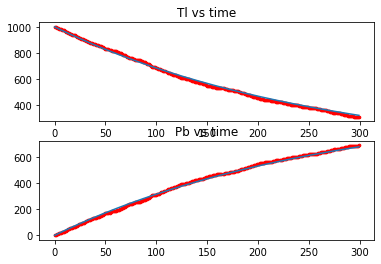

In [2]:
#Per ogni istante di tempo fissato un nucleo abbiamo un esperimento che ha solo due possibili esiti (decade/non decade) con probabilità p e 1-p (rispettivamente); in particolare si tratta di un Bernoulli trial. Poiché fissato ogni istante di tempo abbiamo un Bernoulli trial per ogni nucleo la distribuzione binomiale di scipy.stats fa al caso nostro. Basta specificare che per ogni intervallino di tempo dt la probabilità "locale" che un qualunque nucleo decada è lambda*dt (è p(t) solo quando si considerano osservazioni "cumulative", mentre noi passo passo vogliamo generare il numero di nuclei decaduti in un dato istante)

half_life = 3.052*60 #emivita in secondi
lam = np.log(2)/half_life #lambda è una reserved keyword
N_0 = 1000 #Numero totale di nuclei
N = N_0

_ , (ax1,ax2) = plt.subplots(2);
#plt.figure()

T = 300 #tempo di osservazione in secondi
x = np.zeros((T,)) #non è necessario salvare i valori calcolati, possono anche essere graficati al volo; ho notato però che così è più veloce

for t in np.arange(T) :
    #ax1.scatter(t,N,c="red",s=7)
    #ax2.scatter(t,N_0-N,c="red",s=7)
    x[t] = N
    N -= sps.binom.rvs(n=N,p=lam) #la probabilità di decadere per unità di tempo (1 s) è lambda*1 secondo. 

time = np.arange(T)
y = N_0*2**(-time/half_life)
ax1.scatter(time,x,c="red",s=7)
ax1.plot(time,y);
ax1.set_title("Tl vs time");
ax2.scatter(time,N_0-x,c="red",s=7)
ax2.plot(time,N_0-y);
ax2.set_title("Pb vs time");

#chiaramente si può agire diversamente. Ad esempio si possono generare N_0 numeri casuali estratti da una distribuzione uniforme, ciclare sul tempo e ad ogni istante di tempo contare quanti di questi sono minori/maggiori di p(t); in tal modo stiamo applicando il metodo del rigetto per generare numeri mediante la distribuzione dettata da p(t), e pertanto gli N_0 valori estratti assumono il significato di "tempi ai quali un particolare nucleo decade". Così si possono costruire gli array delle popolazioni in funzione del tempo. 
#è chiaro che questo approccio è di tipo "globale" in quanto stiamo considerando le probabilità cumulative in intervalli di tempo di osservazione estesi (cfr https://physics.stackexchange.com/questions/229632/calculate-the-probability-that-a-radioactive-nucleus-will-have-decayed-after-the), quindi si cicla sul tempo solo per costruire gli array anziché per simulare dinamicamente cosa accada (nel qual caso ciò che conta è la probabilità "istantanea" perché non si ha conoscenza del passato, si osserva solo un istante)

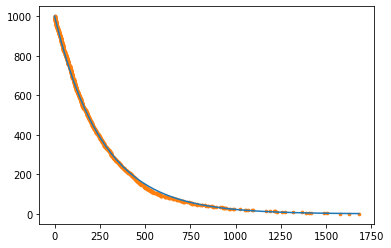

In [10]:
#la densità di probabilità dp/dt per questo problema è 2^(-t/tau) ln 2/tau. è facile integrare fra -inf e t tale funzione; in questo modo si ottiene la cdf p(t)=1-2^(-t/tau), la cui inversa è t = -(tau/ln 2)*ln(1-p). p(t) rappresenta la probabilità che un dato nucleo osservato per un tempo t decada alla fine di quell'intervallo; generando 1000 numeri casuali mediante tale distribuzione di probabilità possiamo ricavare quale frazione dei nuclei decada in un dato tempo. 

def decay_time_gen(p,tau) :
    return -(tau/np.log(2))*np.log(1-p)

#a questo punto genero mediante inverse sampling 1000 valori mediante la distribuzione di cui sopra. Ognuno dei valori estratti rappresenta un istante in corrispondenza del quale decade un nucleo; pertanto se in uno scatter plot accoppio ciascuno di questi istanti a n_nuclei -= 1 ottengo il grafico cercato. 
time_arr = np.sort(decay_time_gen(np.random.uniform(size=N_0),half_life)) #ordino con sort perché mi interessa un plot "leggibile"
#print(time_arr)

pop = np.arange(N_0)[::-1] #pop = popolazione dei nuclei. [::-1] è per invertire; così costruisco [N_0-1, N_0-2, ..., 0]. Far partire questo array da N_0 imporrebbe aggiungere a mano uno 0 all'inizio dell'array dei tempi; lo faccio dopo a mano direttamente nello scatterplot. 
#print(pop)

plt.scatter(0,N_0,s=7);
plt.scatter(time_arr,pop,s=7);

time_plot = np.linspace(0,time_arr[len(time_arr)-1]) #istante di tempo finale = ultimo elemento di time_arr (visto che questo è già ordinato, se no max)
z = N_0*2**(-time_plot/half_life) #in alternativa posso riciclare y dalla cella precedente restringendo i tempi usando qualcosa come t[t < T] dove T era 300
plt.plot(time_plot,z);

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [25]:
#le particelle con theta > pi/2 ovviamente soddisfano anche theta/2 > pi/4; prendendo la tangente di ambo i membri la disequazione resta valida (in questo intervallo la tangente non è regolare ed è monotona crescente, quindi non ci sono problemi) e sfruttando la legge di Rutherford ottengo che Ze^2/(...) > tan(pi/4)=1
#di conseguenza mi basta generare il fascio di particelle e cercare quelle che soddisfano la condizione Ze^2/(...)>1, che è equivalente a b<Ze^2/(2*pi*eps*E)

from scipy import constants #comodo
#parametri fisici
n_particles = int(1e6) #multivariate_normal sotto vuole un intero
Z = 79
e = constants.physical_constants["atomic unit of charge"][0]
E = 7.7e6*e #SI
eps0 = constants.epsilon_0
a0 = constants.physical_constants["atomic unit of length"][0]
b_bounce = Z*e**2/(2*np.pi*eps0*E)

#a questo punto posso generare il fascio gaussiano. Lavorando su un piano mi basta generare una coppia (x,y) (i.e. la posizione) di ogni particella. Per farlo posso usare multivariate_normal; ho bisogno di specificare la media per x e y (0) e la varianza per entrambe mediante la matrice delle covarianze, che in questo caso è diag([var,var])
var = (a0/100)**2
cov_m = np.diag([var,var])
pos = np.random.multivariate_normal([0,0], cov_m, n_particles) #2 colonne (x e y), 1e6 righe (una per particella)

#print(pos.shape)
#a questo punto posso contare le particelle con b<b_bounce. Posso contare ad esempio con np.count_nonzero(condizione), con len(pos[condizione]) o con un for+if
n_bounce = np.count_nonzero(np.sqrt(pos[:,0]**2 + pos[:,1]**2) < b_bounce)
print(f"The fraction of scattered particles is: {n_bounce/n_particles*100} %")

The fraction of scattered particles is: 0.1525 %


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [4]:
N_points = 10000

def f(x) :
    return (np.sin(1/(x*(2-x))))**2

#il rettangolo [0,2]x[0,1] dovrebbe bastare in quanto f(x)<=1
#hit or miss:
x = 2*np.random.rand(N_points) #x in [0,2]
y = np.random.rand(N_points) #y in [0,1]
A_hm = 2*np.count_nonzero(y < f(x))/N_points
A_exact = quad(f,0,2)[0]
print("area with hit or miss MC:",A_hm)
print("exact result:",A_exact)
print(f"percent error: {100*np.abs(A_hm-A_exact)/A_exact}")
A_mean = 2*np.mean(f(x))
print("\n")
print("area with mean MC:",A_mean)
print("exact result:",A_exact)
print(f"percent error: {100*np.abs(A_mean-A_exact)/A_exact}")

area with hit or miss MC: 1.4426
exact result: 1.4516877509810684
percent error: 0.626012789246632


area with mean MC: 1.446640914509046
exact result: 1.4516877509810684
percent error: 0.34765303135000664


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



2D area: 3.1872


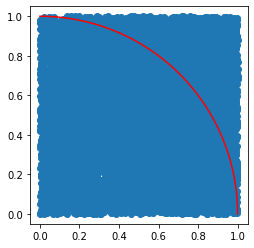

In [5]:
#2D: la prima colonna rappresenta le x dei punti, la seconda le y
N_points = 10000

M_2d = np.random.rand(N_points,2)#attenzione che così genero solo numeri con coordinate comprese fra 0 e 1, cioè prendo solo il prino quadrante --> un quarto del risultato cercato!
norms_2d = np.linalg.norm(M_2d,axis=1)#l'area del quadrato [0,1]x[0,1] è unitaria quindi non devo preoccuparmi di moltiplicare per essa

A = 4*np.count_nonzero(norms_2d <= 1)/N_points #posso rendere il tutto più compatto come nella cella seguente, ma intanto faccio un plot qui
print("2D area:",A)

#plot
theta = np.linspace(0,np.pi/2,1000)
plt.plot(np.cos(theta),np.sin(theta),c="red");
plt.scatter(M_2d[:,0],M_2d[:,1]);
plt.axis("scaled");

In [6]:
N_points = 100000
#2D
A = 4*np.count_nonzero(np.linalg.norm(np.random.rand(N_points,2),axis=1) <= 1)/N_points
print("2D area:",A)

#il comando precedente si generalizza facilmente a 10 dimensioni; aggiungo altre 8 colonne in modo che le 10 colonne rappresentino le 10 coordinate dei vari punti, e calcolando le norme lungo le righe ottengo i valori relativi a ciascun punto. Adesso però per semplicità è meglio generare i numeri in modo che ogni x_i sia fra -1 e 1, in modo da riprodurre direttamente l'ipercubo di lato 2 centrato sull'origine e allineato agli assi (se non altro per non doversi preoccupare per quale fattore moltiplicare)
vol = 2**10*np.count_nonzero(np.linalg.norm((2*np.random.rand(N_points,10)-1),axis=1) <= 1)/N_points #devo moltiplicare per l'ipervolume del cubo di lato 2 considerato
print("10D hypervolume:",vol) #in generale il volume di un ipercubo di lato l in n dimensioni è l^n

from scipy.special import gamma
print("exact result for a 10D sphere:",np.pi**5/gamma(6)) #https://en.wikipedia.org/wiki/Volume_of_an_n-ball

2D area: 3.14628
10D hypervolume: 2.59072
exact result for a 10D sphere: 2.550164039877345


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result of about 0.84

In [11]:
#il nostro integrale sarà dato dalla media di f(x)/w(x) per l'integrale di w(x). 

N_points = 10000

def fun(x) :
    return 1/(np.sqrt(x)*(np.exp(x)+1))

def w(x) :
    return 1/np.sqrt(x)
#genero ogni x in [0,1] ma non uniformemente: devo estrarre le x secondo la w, cosa fattibile mediante la icdf u^2/4 (calcolo analitico)
x = (np.random.rand(N_points))**2/4
x *= 4 #nota: calcolando a mano l'integrale mi risulta che bisogni dividere per 2^2=4 (come fatto nella riga precedente), ma solo eliminando questo /4 (come fatto in questa riga) ottengo il risultato corretto. O ho sbagliato il conto o mi sfugge qualcosa
A_w = np.mean(fun(x)/w(x))*2
#print("int. of w between 0 and 1:", quad(w,0,1)[0], "analytic result:",2) #il risultato esatto si calcola subito come 2*sqrt(x)|_0^1
print("Area with importance sampling MC:",A_w)
print("exact result:",quad(fun,0,1)[0])

Area with importance sampling MC: 0.8389007784693575
exact result: 0.8389329600133858
